# IBM Optimizations using Qiskit

In [1]:
import numpy as np
import qiskit

import qiskit_superstaq as qss

In [2]:
# Provide your api key to the using the "api_key" argument if
# SUPERSTAQ_API_KEY environment variable is not set.
provider = qss.superstaq_provider.SuperstaQProvider()

In [3]:
qc = qiskit.QuantumCircuit(2)
qc.swap(0, 1)
print(qc)

        
q_0: ─X─
      │ 
q_1: ─X─
        


In [4]:
out = provider.ibmq_compile(qc, target="ibmq_jakarta_qpu")

In [5]:
print(out.circuit)

     ┌─────────┐┌───────────┐┌─────────┐ ┌─────────┐┌───────┐┌───────────┐»
q_0: ┤ Rz(π/2) ├┤0          ├┤ Rz(π/2) ├─┤ Rx(π/2) ├┤ Rz(π) ├┤0          ├»
     └─────────┘│  Acecr_mp │├─────────┴┐├─────────┤└───────┘│  Acecr_pm │»
q_1: ───────────┤1          ├┤ Rz(3π/2) ├┤ Rx(π/2) ├─────────┤1          ├»
                └───────────┘└──────────┘└─────────┘         └───────────┘»
q_2: ─────────────────────────────────────────────────────────────────────»
                                                                          »
q_3: ─────────────────────────────────────────────────────────────────────»
                                                                          »
q_4: ─────────────────────────────────────────────────────────────────────»
                                                                          »
q_5: ─────────────────────────────────────────────────────────────────────»
                                                                          »
q_6: ───────

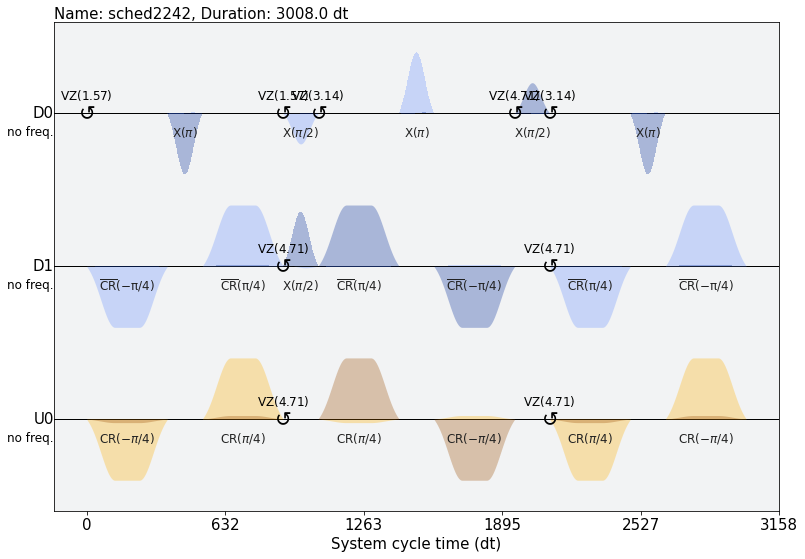

In [6]:
out.pulse_sequence.draw()

In [7]:
# can alternatively pass in a list of quantum circuits
qc0, qc1 = qiskit.QuantumCircuit(2), qiskit.QuantumCircuit(2)
qc0.append(qss.custom_gates.AceCR("+-"), [1, 0])
qc1.append(qss.custom_gates.AceCR("-+", np.pi / 2), [1, 0])

out = provider.ibmq_compile([qc0, qc1], target="ibmq_jakarta_qpu")

In [8]:
print(out.circuits[0])

     ┌──────────┐┌─────────┐┌─────────┐ ┌───────────┐┌─────────┐┌─────────┐»
q_0: ┤ Rz(3π/2) ├┤ Rx(π/2) ├┤ Rz(π/4) ├─┤0          ├┤ Rz(π/4) ├┤ Rx(π/2) ├»
     ├─────────┬┘├─────────┤├─────────┴┐│  Acecr_pm │├─────────┤├─────────┤»
q_1: ┤ Rz(π/4) ├─┤ Rx(π/2) ├┤ Rz(3π/2) ├┤1          ├┤ Rz(π/2) ├┤ Rx(π/2) ├»
     └─────────┘ └─────────┘└──────────┘└───────────┘└─────────┘└─────────┘»
q_2: ──────────────────────────────────────────────────────────────────────»
                                                                           »
q_3: ──────────────────────────────────────────────────────────────────────»
                                                                           »
q_4: ──────────────────────────────────────────────────────────────────────»
                                                                           »
q_5: ──────────────────────────────────────────────────────────────────────»
                                                                           »

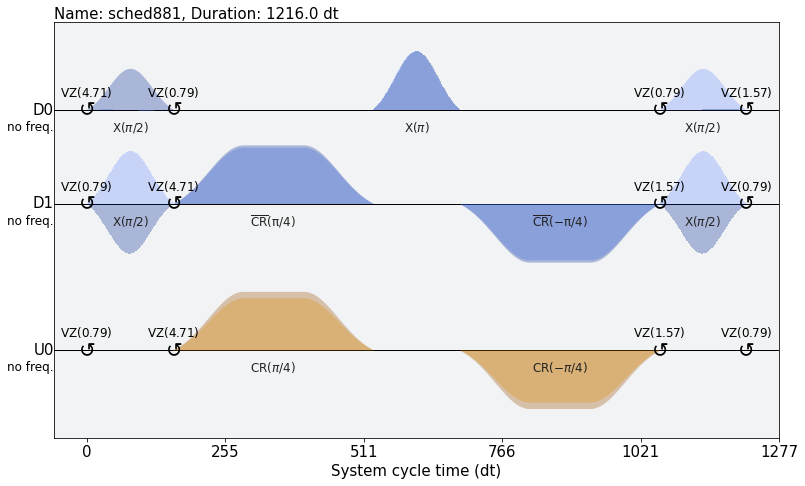

In [9]:
out.pulse_sequences[0].draw()

In [10]:
print(out.circuits[1])

     ┌──────────┐┌─────────┐┌────────────┐┌───────────┐┌────────────┐»
q_0: ┤ Rz(3π/2) ├┤ Rx(π/2) ├┤ Rz(6.1413) ├┤0          ├┤ Rz(1.4289) ├»
     ├──────────┤├─────────┤└┬─────────┬─┘│  Acecr_pm │└┬──────────┬┘»
q_1: ┤ Rz(3π/4) ├┤ Rx(π/2) ├─┤ Rz(π/2) ├──┤1          ├─┤ Rz(3π/2) ├─»
     └──────────┘└─────────┘ └─────────┘  └───────────┘ └──────────┘ »
q_2: ────────────────────────────────────────────────────────────────»
                                                                     »
q_3: ────────────────────────────────────────────────────────────────»
                                                                     »
q_4: ────────────────────────────────────────────────────────────────»
                                                                     »
q_5: ────────────────────────────────────────────────────────────────»
                                                                     »
q_6: ────────────────────────────────────────────────────────────────»
      

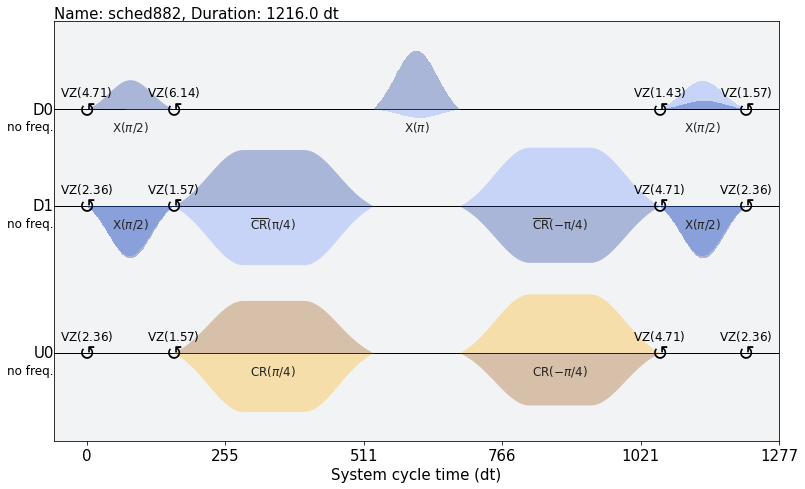

In [11]:
out.pulse_sequences[1].draw()